In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

/Users/conormd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


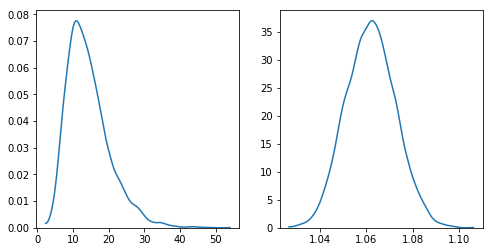

In [5]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1,2, figsize=(8,4))
pm.kdeplot(big, ax=ax[0])
pm.kdeplot(small, ax=ax[1]);

In [8]:
df = pd.read_table("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv", sep=";")
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [11]:
df.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [15]:
heights_mod = pm.Model()

# h ~ N(mu, sig)
# mu ~ N(m,, sd)
# sig ~ hC(b)

with heights_mod:
    
    mu = pm.Normal("mu", mu=135, sd=30, testval=)
    sig = pm.HalfCauchy("sig", beta=3)
    
    h = pm.Normal("h", mu=mu, sd=sig, observed=df.height)
    
    h_mu_estimates = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/conormd/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sig_log__, mu]
100%|██████████| 2000/2000 [00:01<00:00, 1070.44it/s]


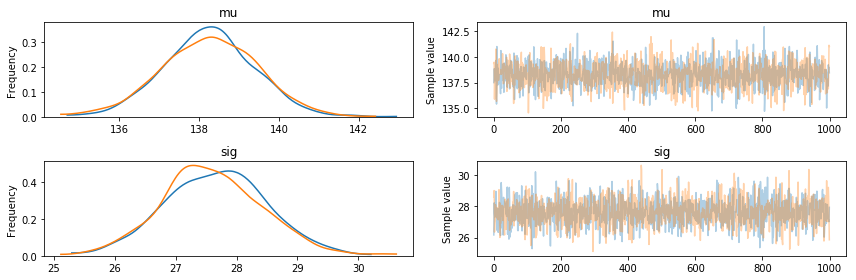

In [17]:
pm.traceplot(h_mu_estimates);

In [21]:
h_estimates_df = pm.trace_to_dataframe(h_mu_estimates)

In [30]:
# heights ~ alpha + beta * weight
# heights ~ Normal(mu, sig)
# mu ~ alpha + beta * weight 
# sig ~ U(0, 50)

# alpha ~ Normal(m, u)
# beta ~ Normal(m, u)

with pm.Model() as lm:
    # intercept
    a = pm.Normal("a", mu=178, sd=100)
    # slope
    b = pm.Normal("b", mu=0, sd=10)
    # random error
    err = pm.Uniform("err", 0, 50)
    
    # linear model
    mu = a + b * df.weight
    
    # likelihood function
    y = pm.Normal("y", mu=mu, sd=err, observed=df.height)
    
    lm_trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/conormd/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [err_interval__, b, a]
100%|██████████| 3000/3000 [00:04<00:00, 732.99it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1128ee080>,
      dtype=object)

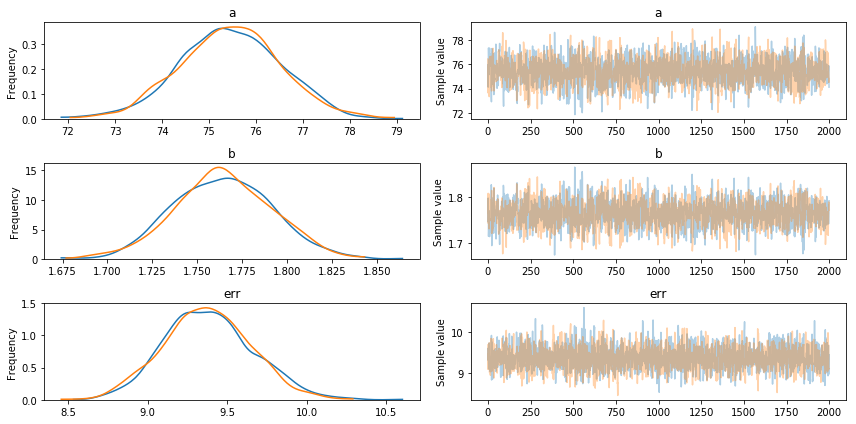

In [31]:
pm.traceplot(lm_trace)

In [32]:
pm.summary(lm_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,75.434191,1.073049,0.025526,73.447600,77.599020,1679.0,0.999756
b,1.764198,0.027406,0.000660,1.711524,1.818290,1665.0,0.999770
err,9.378617,0.276063,0.005406,8.834648,9.904728,2422.0,1.001205


In [36]:
gender = df.male.values

In [39]:
with pm.Model() as glm:
    # intercept
    a = pm.Normal("a", mu=178, sd=100)
    # slope
    b = pm.Normal("b", mu=0, sd=10)
    # random error
    err = pm.Uniform("err", 0, 50)
    
    ag = pm.Normal("ag", mu=170, sd=50, shape=2)
    bg = pm.Normal("bg", mu=0, sd=10, shape=2)
    
    inter = pm.Deterministic("inter", a + ag)
    slope = pm.Deterministic("slope", b + bg)
    
    # linear model
    mu = inter[gender] + slope[gender] * df.weight
    
    # likelihood function
    y = pm.Normal("y", mu=mu, sd=err, observed=df.height)
    
    lm_trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/conormd/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bg, ag, err_interval__, b, a]
100%|██████████| 3000/3000 [04:57<00:00, 10.08it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [39]:
with pm.Model() as glm:
    # intercept
    a = pm.Normal("a", mu=178, sd=100)
    # slope
    b = pm.Normal("b", mu=0, sd=10)
    # random error
    err = pm.Uniform("err", 0, 50)
    
    ag = pm.Normal("ag", mu=170, sd=50, shape=2)
    bg = pm.Normal("bg", mu=0, sd=10, shape=2)
    
    inter = pm.Deterministic("inter", a + ag)
    slope = pm.Deterministic("slope", b + bg)
    
    # linear model
    mu = inter[gender] + slope[gender] * df.weight
    
    # likelihood function
    y = pm.Normal("y", mu=mu, sd=err, observed=df.height)
    
    lm_trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/conormd/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bg, ag, err_interval__, b, a]
100%|██████████| 3000/3000 [04:57<00:00, 10.08it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113c4de48>,
      dtype=object)

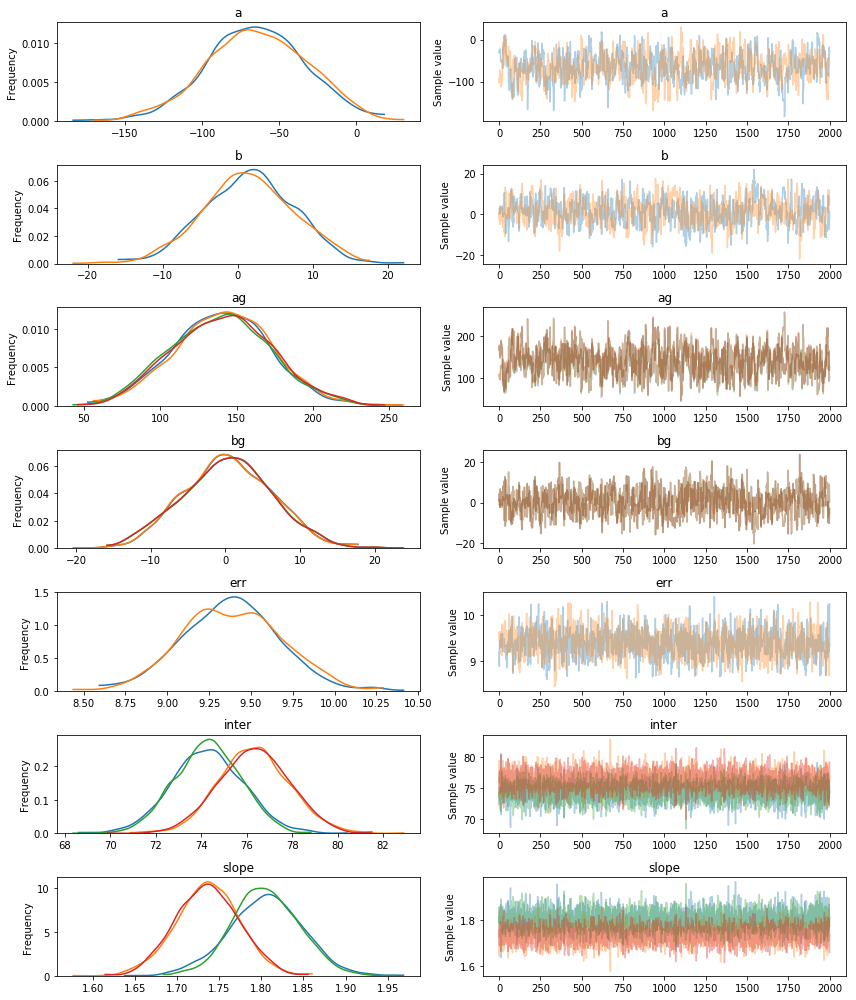

In [40]:
pm.traceplot(lm_trace)

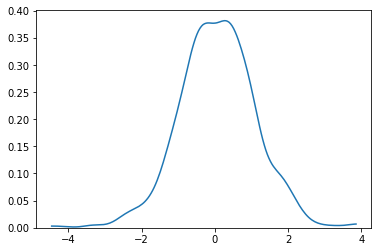

In [48]:
pm.kdeplot(np.random.standard_t(30, size=1000))

In [49]:
from scipy import stats

In [51]:
16**-2

0.00390625

In [54]:
(1/29.) + 1

1.0344827586206897

(array([  8.,  35.,  79., 199., 289., 214., 129.,  34.,   9.,   4.]),
 array([-3.11778678, -2.44754903, -1.77731127, -1.10707351, -0.43683575,
         0.23340201,  0.90363977,  1.57387752,  2.24411528,  2.91435304,
         3.5845908 ]),
 <a list of 10 Patch objects>)

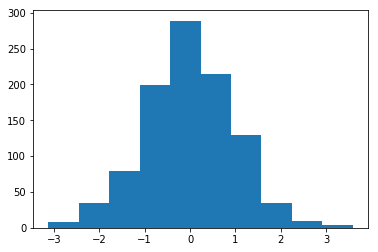

In [58]:
plt.hist(np.random.standard_t(df.shape[0] - 1, 1000))

## Modelling an exponential distribution of streaming days

In [49]:
df = pd.read_csv("Documents/projects/feature_repository/Data/my_streaming_data.txt")

In [53]:
for name in df.columns:
    if "date" in name:
        df[name] = pd.to_datetime(df[name])
#assert df.playback_date_local.dtype == '<M8[ns]'

In [72]:
df["timediff"] = (df.playback_date_local - df.playback_date_local.shift(1)).dt.days.fillna(0)

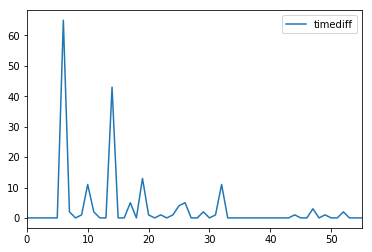

In [74]:
df.loc[:, ["playback_date_local", "timediff"]].plot()

In [84]:
df.timediff

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
6     65.0
7      2.0
8      0.0
9      1.0
10    11.0
11     2.0
12     0.0
13     0.0
14    43.0
15     0.0
16     0.0
17     5.0
18     0.0
19    13.0
20     1.0
21     0.0
22     1.0
23     0.0
24     1.0
25     4.0
26     5.0
27     0.0
28     0.0
29     2.0
30     0.0
31     1.0
32    11.0
33     0.0
34     0.0
35     0.0
36     0.0
37     0.0
38     0.0
39     0.0
40     0.0
41     0.0
42     0.0
43     0.0
44     1.0
45     0.0
46     0.0
47     3.0
48     0.0
49     1.0
50     0.0
51     0.0
52     2.0
53     0.0
54     0.0
55     0.0
Name: timediff, dtype: float64

In [89]:

my_exp = pm.Model()
mean_rate = 1/df.timediff.mean()
with my_exp:
    rate = pm.Exponential("rate", lam=.2)
    mu = pm.Normal("mu", mu=rate, sd=.1, observed=mean_rate)
    trace = pm.sample(3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/conormd/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rate_log__]
100%|██████████| 4000/4000 [00:01<00:00, 3021.70it/s]


In [166]:
trace.get_values("rate").shape

(6000,)

In [92]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
rate,0.319489,0.095712,0.002242,0.139968,0.504162,1648.0,1.000117


In [141]:
expfit = stats.distributions.expon.fit(df.timediff.nonzero());

In [161]:
out = stats.distributions.expon.expect(5, scale=.3).round(3)

TypeError: 'int' object is not callable

In [159]:
out

array([ 0.,  0.,  0.,  0.,  0.,  0., nan, nan,  0., inf, nan, nan,  0.,
        0., nan,  0.,  0., nan,  0., nan, inf,  0., inf,  0., inf, nan,
       nan,  0.,  0., nan,  0., inf, nan,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., inf,  0.,  0., nan,  0., inf,  0.,  0.,
       nan,  0.,  0.,  0.])

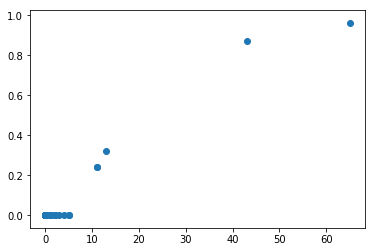

In [153]:
plt.scatter(df.timediff, out)

In [168]:
import pomegranate as pom

In [244]:
exp = pom.distributions.ExponentialDistribution(rate=.11)

In [245]:
exp

{
    "class" :"Distribution",
    "name" :"ExponentialDistribution",
    "parameters" :[
        0.11
    ],
    "frozen" :false
}

In [246]:
exp.fit(df.timediff.nonzero())

In [247]:
exp

{
    "class" :"Distribution",
    "name" :"ExponentialDistribution",
    "parameters" :[
        0.16666668055555534
    ],
    "frozen" :false
}

In [253]:
exp.probability(1)

0.14108029727901086

In [237]:
probabilities = [exp.probability(i) for i in range(65)]

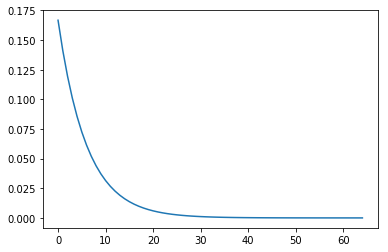

In [224]:
plt.plot(probabilities)

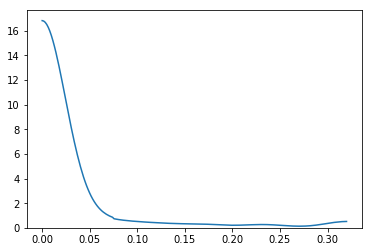

In [212]:
pm.kdeplot(probabilities)

In [4]:
mkt_model = pm.Model()

signups = 6
nleaflets = 16

with mkt_model:
    
    mu = pm.Normal("mu", mu=.4, sd=.1)
    sd = pm.HalfCauchy("sd", beta=.05)
    
    real = pm.Normal("real", mu, sd, observed=signups/nleaflets)
    pm.sample(1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/conormd/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, mu]
100%|██████████| 1500/1500 [00:01<00:00, 942.23it/s]
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6758971218744808, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
